## Initial Data Exploration
Done by: Chamath Wijerathne, Nada Rahali, Tanjuma Haque

In [1]:
# import libraries
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf

C:\Users\anura\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pip install kagglehub
# !pip install statsmodels

## Initial exploratory analysis

In [3]:
# load the dataset
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

print("Path to dataset files:", path)

100%|██████████| 19.4M/19.4M [00:01<00:00, 14.6MB/s]

Extracting files...


Path to dataset files: C:\Users\anura\.cache\kagglehub\datasets\uciml\electric-power-consumption-data-set\versions\1


In [4]:
os.listdir(path)

['household_power_consumption.txt']

In [5]:
file_path = os.path.join(path, "household_power_consumption.txt")
df = pd.read_csv(file_path, sep=";", na_values="?", low_memory=False)
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [6]:
# combine date and time columns
# convert to datetime and set as index
df["DateTime"] = pd.to_datetime(df["Date"] + " " + 
                                df["Time"],format="%d/%m/%Y %H:%M:%S")
df = df.set_index("DateTime")
df = df.drop(columns=["Date", "Time"])

In [7]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
# check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


Some timestamps contain no measurement values at all, the dataset contains 25,979 rows with missing measurement values, corresponding to approximately 1.25% of all timestamps which matches with the dataset description. 

In [9]:
# check for missing timestamps 'jumps' in the datetime index
df.index.to_series().diff().value_counts().head(10)

DateTime
0 days 00:01:00    2075258
Name: count, dtype: int64

Based on the results of the code above, the datetime index shows a consistent 1-minute interval with no missing timestamps meaning we don't need to enforce frequency. Therefore, only the measurement values are missing, not the timestamps which will be addressed through linear interpolation. 

In [10]:
# handle missing values using linear interpolation
df = df.interpolate()
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Now that the dataset is cleaned and the missing values have been handled, we can begin exploring the time-series characteristics.
To understand the dataset better, we will:
1. Check the time range of the dataset (start and end date).

2. Compute the target variable y: y = (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3)
   
   y = the energy used by all the appliances that are not in the 3 sub-meters => unmeasured energy
   
3. Visualize the target variable y over time.
  
1. Identify visible patterns such as daily, weekly, or yearly patterns, trends, or changes in target variable y. 

In [11]:
# check the time range of the dataset (start and end date).
df.index.min(), df.index.max()

(Timestamp('2006-12-16 17:24:00'), Timestamp('2010-11-26 21:02:00'))

In [12]:
# compute the target variable y 
# y = (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3)
df["y"] = (df["Global_active_power"] * 1000 / 60) - df["Sub_metering_1"] - df["Sub_metering_2"] - df["Sub_metering_3"]

In [13]:
df[["y"]].head()

,y
DateTime,
2006-12-16 17:24:00,52.266667
2006-12-16 17:25:00,72.333333
2006-12-16 17:26:00,70.566667
2006-12-16 17:27:00,71.800000
2006-12-16 17:28:00,43.100000


In [14]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,y
DateTime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


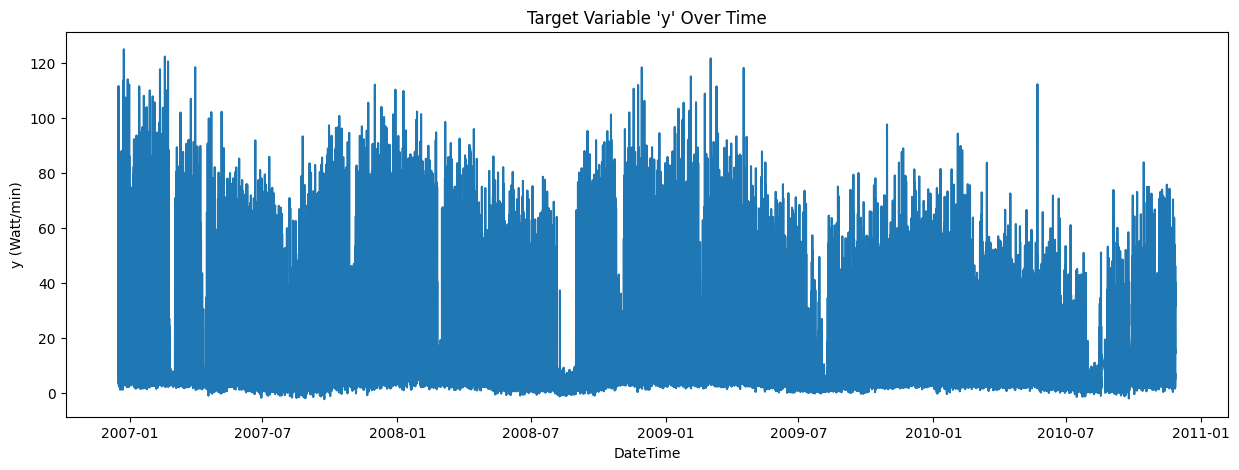

In [15]:
# visualize the target variable 'y' over time 'per minute'
plt.figure(figsize=(15,5))
plt.plot(df.index, df["y"], label="y", color="#1f77b4")
plt.xlabel("DateTime")
plt.ylabel("y (Watt/min)")
plt.title("Target Variable 'y' Over Time")
plt.show()


The minute-level plot is highly noisy, which was a bit hard to understand and explain, that is why the hourly and daily plots are visualized to better understand the seasonality shape. 

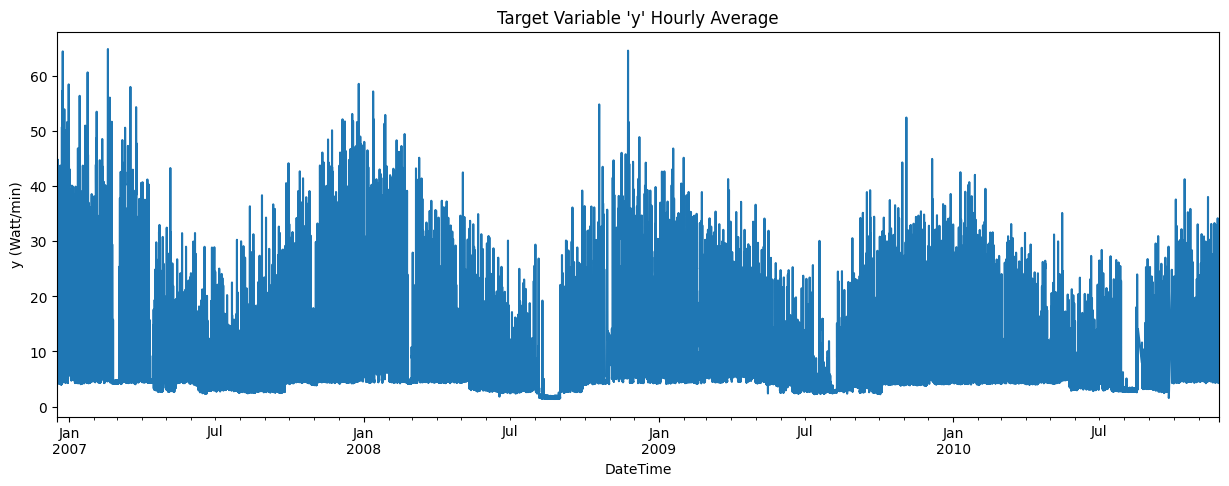

In [16]:
# visualize the target variable 'y' hourly
plt.figure(figsize=(15,5))
df["y"].resample("h").mean().plot()
plt.title("Target Variable 'y' Hourly Average")
plt.xlabel("DateTime")
plt.ylabel("y (Watt/min)")
plt.show()


The hourly averaged data shows the same general seasonal structure: 
- higher peaks during certain hours (morning/evening)
- lower consumption overnight
- seasonal differences more clearly

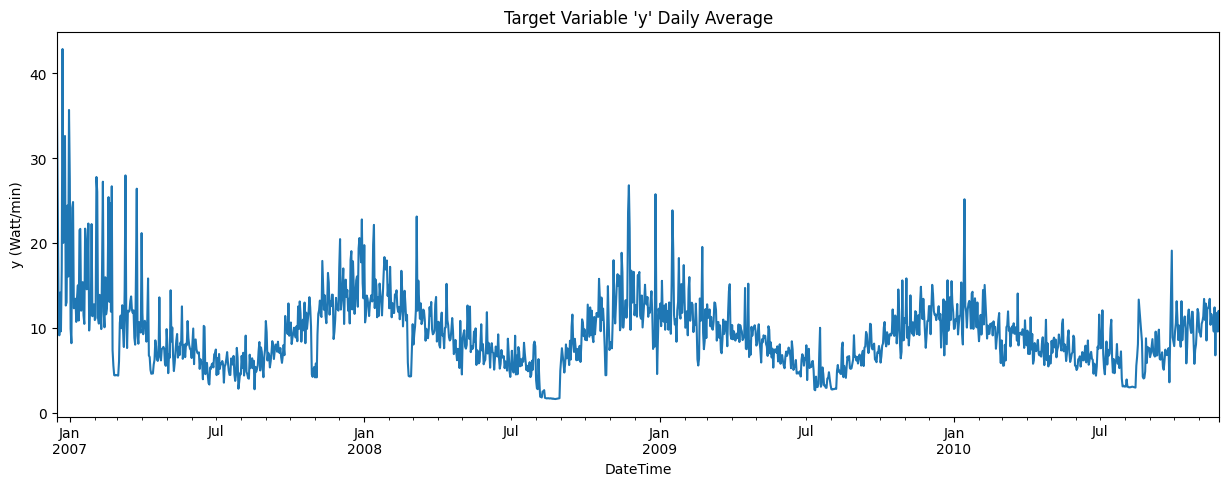

In [17]:
# visualize the target variable 'y' daily
plt.figure(figsize=(15,5))
y_daily = df["y"].resample("D").mean()
y_daily.plot()
plt.title("Target Variable 'y' Daily Average")
plt.xlabel("DateTime")
plt.ylabel("y (Watt/min)")
plt.show()

Energy usage is highest during the winter months (December–February), where the daily average reaches approximately 20–30 Wh/min. This is likely happening due to eletric heating, lights for longer hours, water heaters.. 

From January to July, the daily averages gradually decrease, reaching a minimum of around 5–10 Wh/min in midsummer. During summer months, heating demand is less compared to winter, daylight hours are longer, and residents tend to use fewer appliances.

From July onward, consumption increases again as winter approaches, repeating the seasonal cycle each year.

## Time-series decomposition analysis of long-term trend, seasonality, and residuals

In [18]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,y
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.090280e+00,1.236492e-01,2.408328e+02,4.621481e+00,1.109485e+00,1.289229e+00,6.442386e+00,9.330226e+00
std,1.052628e+00,1.124194e-01,3.237763e+00,4.424361e+00,6.115843e+00,5.786613e+00,8.415860e+00,9.546528e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.100000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.833333e+00
50%,6.140000e-01,1.000000e-01,2.410000e+02,2.751585e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.533333e+00
75%,1.528000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.046667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


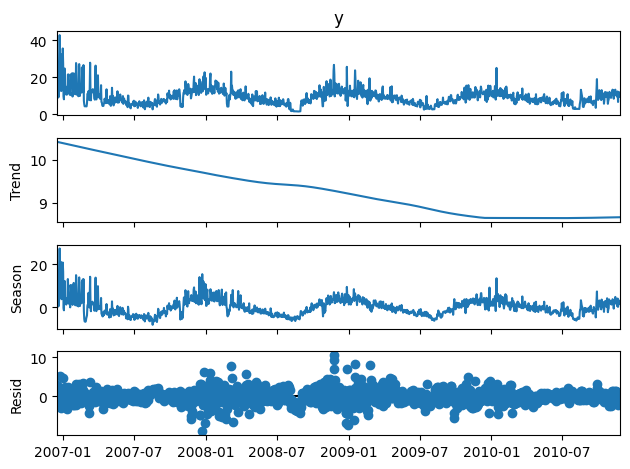

In [19]:
# STL decomposition on daily data
stl = STL(y_daily, period=365)
res = stl.fit()
fig = res.plot()


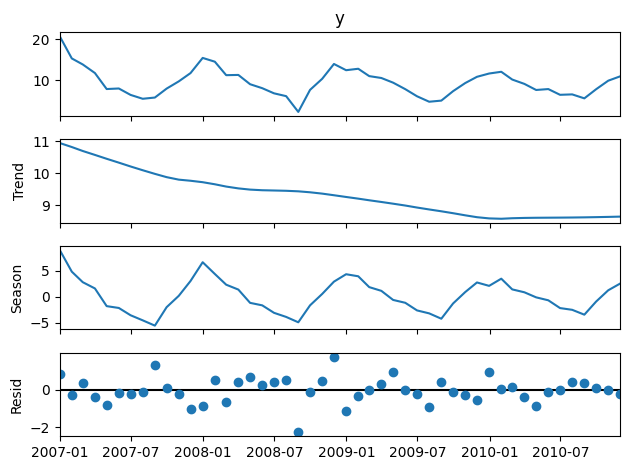

In [20]:
# STL decomposition on monthly data
y_monthly = df["y"].resample("ME").mean()

stl = STL(y_monthly, period=12, seasonal=13, trend=21)
res = stl.fit()
res.plot()
plt.show()


Based on my understandings of the plots, the stl decomposition shows 3 main components: 

- Observed: the daily plot is very spiky, because energy usage differ a lot day-to-day. However, in the monthly data, it is much cleaner which is best for interpretation. 

- Trend => long-term upward: The long-term trend is lightly decreasing from ~11 to ~9 same goes for the monthly data. 

- Seasonality => repeating yearly patterns: Higher energy consumption during winter months (December–February), which means more energy. While, Lower energy usage during summer months (June–August) => less energy. 

- Residual => random noise: The residuals of the daily STL decomposition are mostly small and randomly distributed around zero, which does not show clear patterns of daily ouliers, in this case applying the robust fitting will be better to make the decomposition more robust to outliers. Compared to monthly stl, residuals looks clean no need for robust fitting. 

However, monthly decomposition shows smoother and more interpretable components, while daily decomposition is noisier and benefits from robust fitting.

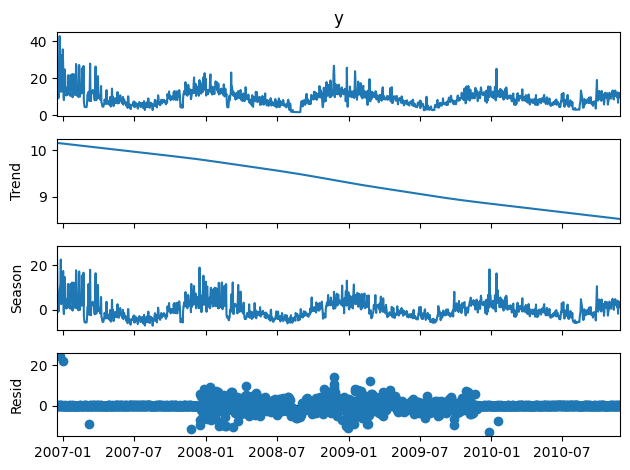

In [21]:
# robust fitting stl on daily data
stl_robust = STL(y_daily, period=365, robust=True)
res_robust = stl_robust.fit()
res_robust.plot()
plt.show()

Robust fitting (robust=True) was used to prevent these outliers from distorting the trend and seasonality.The residual component appears noisy with visible outliers, because if we look at the y-series, daily consumption is irregular, some days have very high power use. When STL removes the trend and seasonality, those unpredictable jumps end up in the residual plot.

## An autocorrelation analysis of the dataset

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

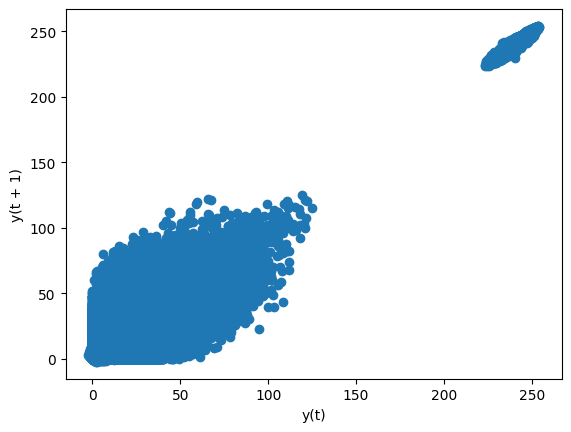

In [22]:
# autocorrelation analysis lag(1) - today vs yesterday
df.head(15)
pd.plotting.lag_plot(df, lag=1)

The scatter plot shows y(t) on the x-axis and y(t+1) (the next observation) on the y-axis. There are 2 seperate groups of points: cluster 1, values between 0 and 120 representing majority of the data, which I suppose the standard behaviour (daily patterns). While cluster 2 cointains fewer points around 220 and 260 and they are very close together. 

In [23]:
# create lagged dataframe for autocorrelation matrix
y = df["y"].copy()

# Create lagged versions
df_lags = pd.DataFrame({
    "y(t-3)": y.shift(3),
    "y(t-2)": y.shift(2),
    "y(t-1)": y.shift(1),
    "y(t)":   y,
})

# remove rows with NaN due to shifting
df_lags = df_lags.dropna()

# compute correlation matrix
corr_matrix = df_lags.corr()
corr_matrix

,y(t-3),y(t-2),y(t-1),y(t)
y(t-3),1.000000,0.952737,0.907180,0.877162
y(t-2),0.952737,1.000000,0.952738,0.907179
y(t-1),0.907180,0.952738,1.000000,0.952737
y(t),0.877162,0.907179,0.952737,1.000000


<Figure size 1400x600 with 0 Axes>

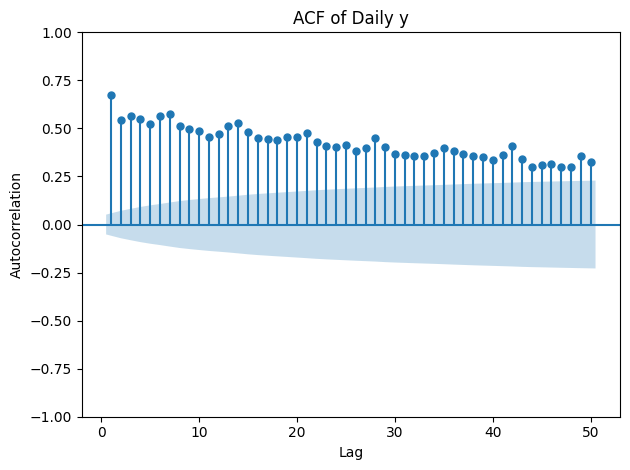

In [24]:
plt.figure(figsize=(14,6)) 
plot_acf(
    y_daily, 
    lags=50,
    zero=False,          
)
plt.title("ACF of Daily y")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()


The autocorrelation starts at 0.70 which means that today’s consumption is highly dependent on yesterday’s value 'lag(1)'. The autocorrelation decreases gradually but remains well above zero for more than 50 lags, meaning that past values influence the future values . 